# NYC Taxi fare prediction - Neural Models

## Parametrization

In [ ]:
import ipywidgets as widgets
from IPython.display import display

# Save/load path for models
baseline_model_path_widget = widgets.Text(description='Baseline model',
                                          value='baseline.model')
outsiders_model_path_widget = widgets.Text(description='Outsiders model',
                                           value='outsiders.model')
urban_model_path_widget = widgets.Text(description='Urban model',
                                       value='urban.model')

# Load paths of the dataset
train_path_widget = widgets.Text(description='Train set',
                                 value='datasets/train.parquet')
valid_path_widget = widgets.Text(description='Validation set',
                                 value='datasets/valid.parquet')
test_path_widget = widgets.Text(description='Test set',
                                value='datasets/test.parquet')
kaggle_test_path_widget = widgets.Text(description='Kaggle test set',
                                       value='datasets/kaggle_test.parquet')
kaggle_submission_path_widget = widgets.Text(
    description='Kaggle sumbission file',
    value='kaggle_submission.csv')

In [ ]:
display(baseline_model_path_widget)
display(outsiders_model_path_widget)
display(urban_model_path_widget)

display(train_path_widget)
display(valid_path_widget)
display(test_path_widget)
display(kaggle_test_path_widget)
display(kaggle_submission_path_widget)

Text(value='baseline.model', description='Baseline model')

Text(value='outsiders.model', description='Outsiders model')

Text(value='urban.model', description='Urban model')

Text(value='datasets/train.parquet', description='Train set')

Text(value='datasets/valid.parquet', description='Validation set')

Text(value='datasets/test.parquet', description='Test set')

Text(value='datasets/kaggle_test.parquet', description='Kaggle test set')

Text(value='kaggle_submission.csv', description='Kaggle test set')

In [ ]:
baseline_model_path = baseline_model_path_widget.value
outsiders_model_path = outsiders_model_path_widget.value
urban_model_path = urban_model_path_widget.value

train_path = train_path_widget.value
valid_path = valid_path_widget.value
test_path = test_path_widget.value
kaggle_test_path = kaggle_test_path_widget.value
kaggle_submission_path = kaggle_submission_path_widget.value

print('Linear model path:', baseline_model_path)
print('Outsiders model path:', outsiders_model_path)
print('Urban model path:', urban_model_path)

print('Train set path:', train_path)
print('Valid set path:', valid_path)
print('Test set path:', test_path)
print('Kaggle test set path:', kaggle_test_path)
print('Kaggle submission save path:', kaggle_submission_path)

Linear model path: drive/MyDrive/taxifare/baseline.model
Outsiders model path: drive/MyDrive/taxifare/outsiders.model
Urban model path: drive/MyDrive/taxifare/urban.model
Train set path: drive/MyDrive/taxifare/train.parquet
Valid set path: drive/MyDrive/taxifare/valid.parquet
Test set path: drive/MyDrive/taxifare/test.parquet
Kaggle test set path: drive/MyDrive/taxifare/kaggle_test_rich.parquet
Kaggle submission save path: drive/MyDrive/taxifare/kaggle_submission.csv


## Colab setup
Automatically skipped if not working in a colab environment

In [ ]:
on_colab = True
try:
    import google.colab
except ImportError:
    on_colab = False

print('Are we on colab?', on_colab)

Are we on colab? True


Download `taxifare` library, install dependencies, download other related data.

In [ ]:
if on_colab:
    !git clone https://github.com/FaediMichele/TaxiFarePrediction taxi
    !pip install -r taxi/requirements.txt
    !cp -r taxi/taxifare .
    !mkdir datasets/
    !wget https://geodata.lib.utexas.edu/download/file/sde-columbia-nycp_2007_nynh-geojson.json
    !mv sde-columbia-nycp_2007_nynh-geojson.json datasets/

fatal: destination path 'taxi' already exists and is not an empty directory.
mkdir: cannot create directory ‘datasets/’: File exists
--2023-06-27 18:46:06--  https://geodata.lib.utexas.edu/download/file/sde-columbia-nycp_2007_nynh-geojson.json
Resolving geodata.lib.utexas.edu (geodata.lib.utexas.edu)... 128.83.214.42
Connecting to geodata.lib.utexas.edu (geodata.lib.utexas.edu)|128.83.214.42|:443... connected.
HTTP request sent, awaiting response... 500 Internal Server Error
2023-06-27 18:46:07 ERROR 500: Internal Server Error.

mv: cannot stat 'sde-columbia-nycp_2007_nynh-geojson.json': No such file or directory


Sync drive.

In [ ]:
if on_colab:
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load data

In [ ]:
import pickle
import os.path
from typing import Dict, Tuple, Callable
from itertools import cycle

import numpy as np
import polars as pl
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, optimizers, models
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

import taxifare.data as data
import taxifare.boroughs as boroughs
import taxifare.models as taximodels

plt.rcParams['figure.figsize'] = (15, 7)

Loaded data undergoes a small amount of final processing. Heavy preprocessing should be carried out a priori by the `taxifare.preprocess` script.

In [ ]:
def fare_amount_filter(column='fare_amount', min_=0, max_=200):
  return pl.col(column).is_between(0, 200, 'none')

train_lazy = pl.scan_parquet(train_path).filter(fare_amount_filter())
valid_lazy = pl.scan_parquet(valid_path).filter(fare_amount_filter())
test_lazy = pl.scan_parquet(test_path).filter(fare_amount_filter())

In [ ]:
train_df = train_lazy.collect()
valid_df = valid_lazy.collect()
test_df = test_lazy.collect()

In [ ]:
train_df.head()

fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,travel_time,year,month,weekday,hour,after2012,weekend
f64,f64,f64,f64,f64,i64,f64,i32,u32,u32,u32,bool,bool
7.0,-73.981685,40.768332,-73.982392,40.778992,1,36.1875,2014,6,1,14,true,false
9.7,-73.987338,40.768608,-73.993192,40.73648,2,223.75,2011,3,4,22,false,false
15.0,-73.97152,40.762457,-74.003205,40.71805,1,216.125,2014,2,7,0,true,true
6.5,-73.990883,40.755581,-73.982796,40.752808,3,56.1875,2015,4,2,9,true,false
8.9,-73.977457,40.774035,-73.968257,40.80444,1,176.75,2009,7,5,15,false,false


All models are retrieved from the filesystem if found, together with their train histories and fit data policy. If not, they are trained from scratch from the given data.

In [ ]:
def get_model(model_path: str,
              train_data: pl.DataFrame,
              data_policy: taximodels.DataPolicy,
              model_factory: Callable[[taximodels.DataPolicy], keras.Model]
              ) -> Tuple[bool, keras.Model, taximodels.DataPolicy]:
    """Retrieve model either by loading it or creating a new one.

    The given policy is fit on the data if not loaded from file.

    Return a tuple in the form ``(model_was_found, model, data_policy)``.
    """
    policy_path = os.path.join(model_path, 'data_policy.json')
    model_exists = os.path.exists(model_path)
    policy_exists = os.path.exists(policy_path)

    # If model exists load it
    if model_exists:
        model = tf.keras.models.load_model(model_path)
    # Otherwise create the model
    else:
        model = model_factory(data_policy)

    # If the policy exists load it
    if policy_exists:
        data_policy = taximodels.DataPolicy.from_file(policy_path)
    else:
        data_policy.fit(train_df)

    return model_exists, model, data_policy


def save_model(model_path: str, model: keras.Model,
               data_policy: taximodels.DataPolicy):
    """Save model with its policy."""
    policy_path = os.path.join(model_path, 'data_policy.json')

    model.save(model_path)
    data_policy.to_file(policy_path)


def load_history(history_path: str) -> dict:
    """Load history from file if found, return an empty dict otherwise."""
    if not os.path.exists(history_path):
        return {}

    with open(history_path, 'rb') as file:
        return pickle.load(file)


def save_history(history_path: str, history_dict: dict):
    """Save history to file.

    This expects the history dictionary, not the actual History callback
    objects.
    """
    with open(history_path, 'wb') as file:
        pickle.dump(history_dict, file)

## Linear baseline

A linear baseline is produced and inspected.

In [ ]:
def baseline_factory(data_policy: taximodels.DataPolicy) -> keras.Model:
    """Build and compile a baseline model (linear).

    Policy is only used to retrieve the input size. It is not necessary for it
    to be fit.
    """
    model = taximodels.get_cone_mlp(
            len(data_policy.to_input), 1, 2048, 0, name='Linear')
    model.compile(optimizer=optimizers.Adam(), loss='mse')

    return model

In [ ]:
# Craft a data policy for the linear baseline model, with reduced set of
# features
BASELINE_TO_STD = 'fare_amount',
BASELINE_TO_NORM = ('pickup_longitude', 'pickup_latitude',
                    'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
                    'year', 'month', 'weekday', 'hour')

BASELINE_TO_INPUT = ('pickup_longitude', 'pickup_latitude',
                     'dropoff_longitude', 'dropoff_latitude',
                     'passenger_count', 'year', 'month', 'weekday',
                     'hour')

BASELINE_DATA_POLICY = taximodels.DataPolicy(
    BASELINE_TO_STD, BASELINE_TO_NORM,
    BASELINE_TO_INPUT, taximodels.MLP_TO_OUTPUT)

linear_history_path = 'drive/MyDrive/taxifare/linear_history.pkl'

linear_model_exists, linear_model, linear_policy = get_model(
    baseline_model_path,
    train_df,
    BASELINE_DATA_POLICY,
    baseline_factory
)

print('Linear model loaded from file?', linear_model_exists)

Linear model loaded from file? False


In [ ]:
linear_model.summary()

Model: "Linear"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 10        
                                                                 
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


In [ ]:
valid_x, valid_y = linear_policy.split_transform(valid_df)
batch_size = 2048
train_len = len(train_df)
samples_per_epoch = len(train_df)

linear_history = load_history(linear_history_path)

if not linear_model_exists:
    history = linear_model.fit(
        taximodels.iterate_df(train_df, batch_size=batch_size,
                              data_policy=linear_policy),
        callbacks=[keras.callbacks.EarlyStopping(patience=2,
                                                restore_best_weights=True)],
        validation_data=(valid_x.to_numpy(), valid_y.to_numpy()),
        steps_per_epoch=samples_per_epoch // batch_size,
        batch_size=batch_size, epochs=100)

    linear_history = history.history

Epoch 1/100
20849/20849 [==============================] - 106s 5ms/step - loss: 0.6780 - val_loss: 0.6185
Epoch 2/100
20849/20849 [==============================] - 99s 5ms/step - loss: 0.6188 - val_loss: 0.6183
Epoch 3/100
20849/20849 [==============================] - 101s 5ms/step - loss: 0.6187 - val_loss: 0.6183
Epoch 4/100
20849/20849 [==============================] - 98s 5ms/step - loss: 0.6187 - val_loss: 0.6183
Epoch 5/100
20849/20849 [==============================] - 104s 5ms/step - loss: 0.6187 - val_loss: 0.6183
Epoch 6/100
20849/20849 [==============================] - 101s 5ms/step - loss: 0.6187 - val_loss: 0.6183


In [ ]:
save_model(baseline_model_path, linear_model, linear_policy)
save_history(linear_history_path, linear_history)

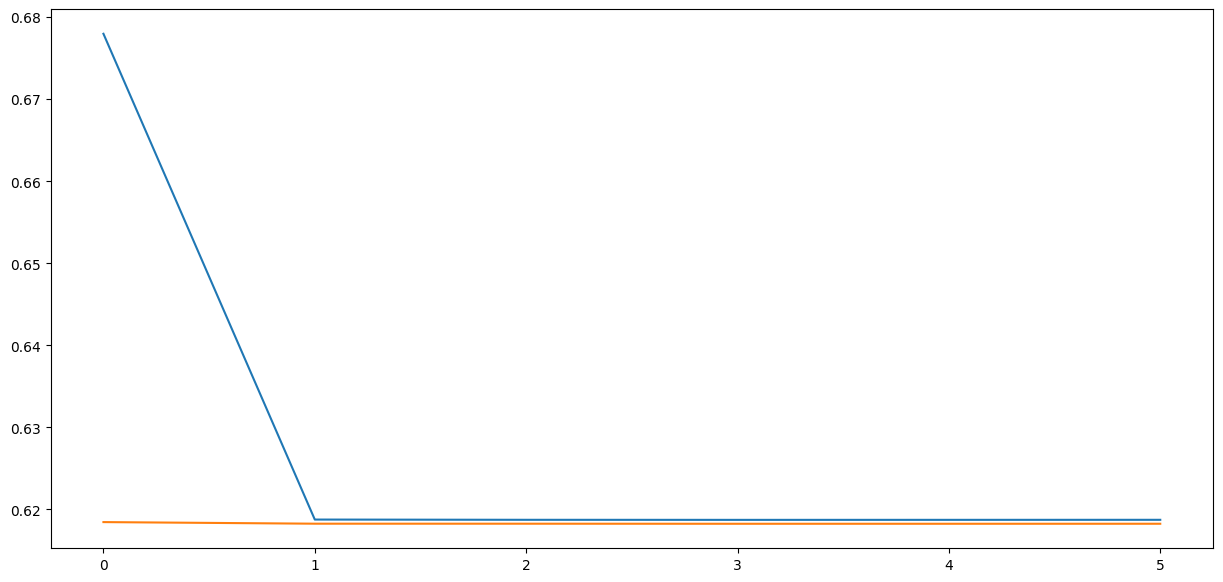

In [ ]:
for key, values in linear_history.items():
    plt.plot(values)

plt.show()

### Evaluation

Evaluation is carried out on the validation set in order to compare the model with the more complex multilayer perceptrons.

In [ ]:
linear_model_eval = taximodels.build_evaluation_nn(linear_model,
                                                   linear_policy)

In [ ]:
# Do not use the valid_y that comes from the policy split, as the label would
# get standardized. Either build an evaluation policy where the label is not
# standardized or (as done here) use a copy of the original label column
linear_pred = linear_model_eval.predict(valid_x.to_numpy(),
                                           batch_size=2 ** 16)
print('Linear validation RMSE:',
      taximodels.rmse(linear_pred.squeeze(),
                      valid_df['fare_amount'].to_numpy()))
print('Dummy mean constant RMSE:',
      taximodels.rmse(
          (tf.ones([len(valid_df['fare_amount'])])
           * linear_policy.mean_dataframe['fare_amount']).numpy(),
          valid_df['fare_amount'].to_numpy()))

82/82 [==============================] - 0s 2ms/step
Linear validation RMSE: 7.041716775164236
Dummy mean constant RMSE: 8.939563073120507


This simple linear model is still better than predicting the constant mean of the train set. The improvement is not majestic as the set of features are using is not necessarily linear-friendly.

In fact, the linear correlation between of some of these features is extremely low, in particular cyclical features.

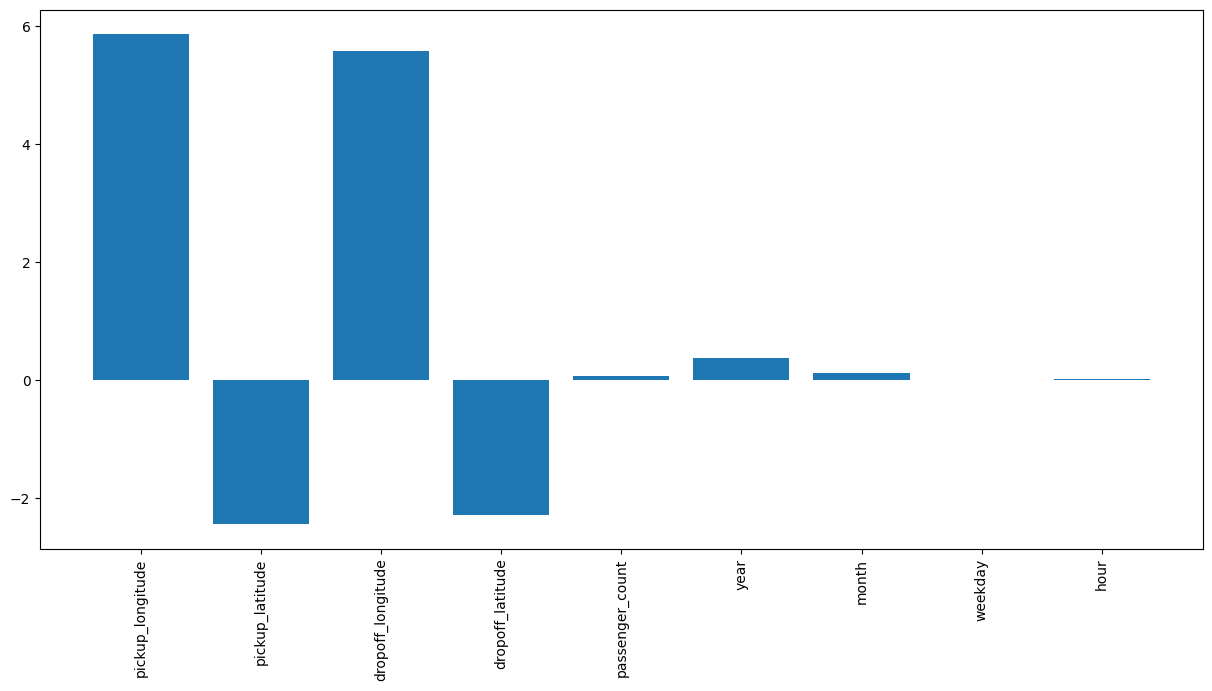

In [ ]:
plt.xticks(rotation=90)
plt.bar(linear_policy.to_input, linear_model.weights[0].numpy().squeeze())
plt.show()

The model reflects the correlation of the features. As expected, `year` and `after2012` reflect the effect of inflation.

## Outsiders model

A more complex non-linear model is represented by a pair of multilayer perceptrons:

* Outsiders model
* Urban model

These two models act in a selective way.

The so called *outsiders* model has a similar definition to the linear one, just with a few extra hidden layers and ReLU non-linearities. Some regularization is added through weight decay. It is trained on the entire dataset, but at prediction time (on the kaggle test set) it is only used for suburban points, i.e. that are not in the New York City urban area.

Even though it is used to predict such points it is not trained on them, mostly because attempts in doing so resulted in very poor performance, supposedly due to the sparsity of such points in the original data.

In [ ]:
def mlp_outsiders_factory(data_policy: taximodels.DataPolicy) -> keras.Model:
    """Build and compile an outsiders model (MLP).

    Policy is only used to retrieve the input size. It is not necessary for it
    to be fit.
    """
    model = taximodels.get_cone_mlp(
            len(data_policy.to_input), 1, 2048, 5, name='OutsidersMLP')
    model.compile(optimizer=optimizers.Adam(weight_decay=1e-3), loss='mse')

    return model

In [ ]:
outsiders_history_path = 'drive/MyDrive/taxifare/outsiders_history.pkl'

outsiders_model_exists, outsiders_model, outsiders_policy = get_model(
    outsiders_model_path,
    train_df,
    taximodels.MLP_DATA_POLICY,
    mlp_outsiders_factory
)

print('Outsiders model loaded from file?', outsiders_model_exists)

Outsiders model loaded from file? True


In [ ]:
outsiders_model.summary()

Model: "OutsidersMLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2048)              24576     
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,811,905
Trainable params: 2,811,905
No

In [ ]:
valid_x, valid_y = outsiders_policy.split_transform(valid_df)
batch_size = 2048
train_len = len(train_df)
samples_per_epoch = len(train_df)

outsiders_history = load_history(outsiders_history_path)

if not outsiders_model_exists:
    history = outsiders_model.fit(
        taximodels.iterate_df(train_df, batch_size=batch_size,
                              data_policy=outsiders_policy),
        callbacks=[keras.callbacks.EarlyStopping(patience=2,
                                                restore_best_weights=True)],
        validation_data=(valid_x.to_numpy(), valid_y.to_numpy()),
        steps_per_epoch=samples_per_epoch // batch_size,
        batch_size=batch_size, epochs=100)

    outsiders_history = history.history

In [ ]:
save_model(outsiders_model_path, outsiders_model, outsiders_policy)
save_history(outsiders_history_path, outsiders_history)

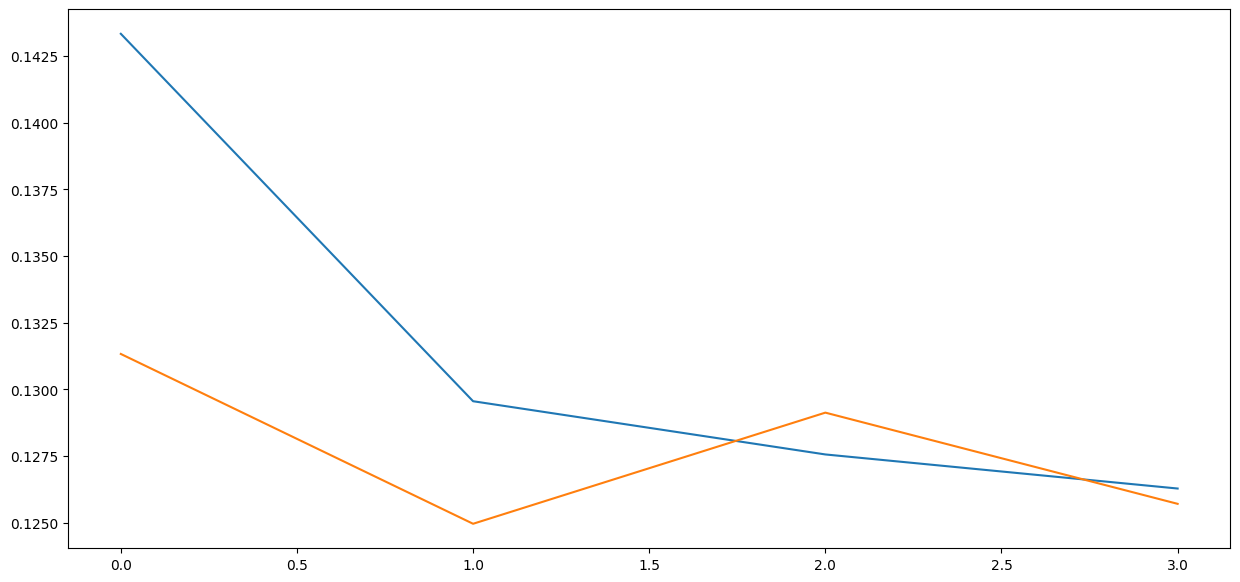

In [ ]:
for key, values in outsiders_history.items():
    plt.plot(values)

plt.show()

### Evaluation

The outisders model is evaluated on the test set to compare it to the performance on the kaggle test set.

In [ ]:
outsiders_model_eval = taximodels.build_evaluation_nn(outsiders_model,
                                                      outsiders_policy)

In [ ]:
# Do not use the test_y that comes from the policy split, as the label would
# get standardized. Either build an evaluation policy where the label is not
# standardized or (as done here) use a copy of the original label column
test_x, _ = outsiders_policy.split_transform(test_df)
outsiders_pred = outsiders_model_eval.predict(test_x.to_numpy(),
                                              batch_size=2 ** 16)
print('Outsiders test RMSE:',
      taximodels.rmse(outsiders_pred.squeeze(),
                      test_df['fare_amount'].to_numpy()))

82/82 [==============================] - 8s 95ms/step
Outsiders test RMSE: 3.1422897156894036


## Urban model

The so called *urban* model has access to extra features which are specific to the New York City area.

At prediction time it is used to predict points in the New York City urban area.

In [ ]:
def mlp_urban_factory(data_policy: taximodels.DataPolicy) -> keras.Model:
    """Build and compile an urban model (MLP).

    Policy is only used to retrieve the input size. It is not necessary for it
    to be fit.
    """
    model = taximodels.get_cone_mlp(
            len(data_policy.to_input), 1, 2048, 5, name='UrbanMLP')
    model.compile(optimizer=optimizers.Adam(weight_decay=1e-3), loss='mse')

    return model

In [ ]:
urban_history_path = 'drive/MyDrive/taxifare/urban_history.pkl'

urban_model_exists, urban_model, urban_policy = get_model(
    urban_model_path,
    train_df,
    taximodels.MLP_URBAN_DATA_POLICY,
    mlp_urban_factory
)

print('Urban model loaded from file?', urban_model_exists)

Urban model loaded from file? True


In [ ]:
urban_model.summary()

Model: "UrbanMLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 2048)              26624     
                                                                 
 dense_7 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_8 (Dense)             (None, 512)               524800    
                                                                 
 dense_9 (Dense)             (None, 256)               131328    
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2,813,953
Trainable params: 2,813,953
Non-tr

In [ ]:
valid_x, valid_y = urban_policy.split_transform(valid_df)
batch_size = 2048
train_len = len(train_df)
samples_per_epoch = len(train_df)

urban_history = load_history(urban_history_path)

if not urban_model_exists:
    history = urban_model.fit(
        taximodels.iterate_df(train_df, batch_size=batch_size,
                              data_policy=urban_policy),
        callbacks=[keras.callbacks.EarlyStopping(patience=2,
                                                 restore_best_weights=True)],
        validation_data=(valid_x.to_numpy(), valid_y.to_numpy()),
        steps_per_epoch=samples_per_epoch // batch_size,
        batch_size=batch_size, epochs=100)

    urban_history = history.history

In [ ]:
save_model(urban_model_path, urban_model, urban_policy)
save_history(urban_history_path, urban_history)

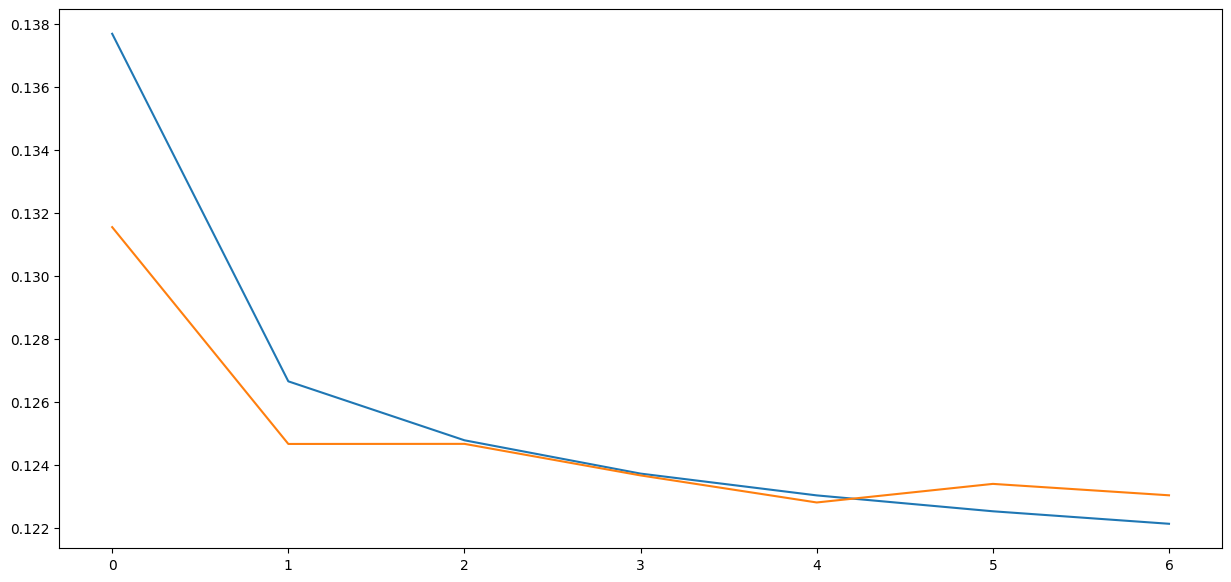

In [ ]:
for key, values in urban_history.items():
    plt.plot(values)

plt.show()

### Evaluation

The urban model is evaluated on the test set to compare it to the performance on the kaggle test set.

In [ ]:
urban_model_eval = taximodels.build_evaluation_nn(urban_model,
                                                  urban_policy)

In [ ]:
# Do not use the test_y that comes from the policy split, as the label would
# get standardized. Either build an evaluation policy where the label is not
# standardized or (as done here) use a copy of the original label column
test_x, _ = urban_policy.split_transform(test_df)
urban_pred = urban_model_eval.predict(test_x.to_numpy(),
                                              batch_size=2 ** 16)
print('Urban test RMSE:',
      taximodels.rmse(urban_pred.squeeze(),
                      test_df['fare_amount'].to_numpy()))

82/82 [==============================] - 8s 96ms/step
Urban test RMSE: 3.115026407713106


## Evaluation on kaggle test set

Finally, the kaggle test set is loaded and predicted. All the necessary features have to be preprocessed a priori.

In [ ]:
kaggle_test = pl.read_parquet(kaggle_test_path)
kaggle_test.head()

key,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,weekday,hour,after2012,weekend,pickup_borough,dropoff_borough,travel_time
str,f64,f64,f64,f64,i64,i32,u32,u32,u32,bool,bool,str,str,f64
"""2015-01-27 13:…",-73.97332,40.763805,-73.98143,40.743835,1,2015,1,2,13,true,false,"""Manhattan""","""Manhattan""",146.75
"""2015-01-27 13:…",-73.986862,40.719383,-73.998886,40.739201,1,2015,1,2,13,true,false,"""Manhattan""","""Manhattan""",121.875
"""2011-10-08 11:…",-73.982524,40.75126,-73.979654,40.746139,1,2011,10,6,11,false,true,"""Manhattan""","""Manhattan""",56.40625
"""2012-12-01 21:…",-73.98116,40.767807,-73.990448,40.751635,1,2012,12,6,21,true,true,"""Manhattan""","""Manhattan""",128.5
"""2012-12-01 21:…",-73.966046,40.789775,-73.988565,40.744427,1,2012,12,6,21,true,true,"""Manhattan""","""Manhattan""",267.0


Both the *urban* and *outsiders* predict over the entire kaggle test set. Results are then composed based on the pickup/dropoff boroughs of the samples. A borough with value `None` identifies a suburban point.

In [ ]:
kaggle_test_outsiders = (
    outsiders_policy.transform(kaggle_test, transform_output=False)
                    .select(outsiders_policy.to_input)
                    .to_numpy()
)

kaggle_outsiders_pred = outsiders_model_eval.predict_on_batch(
    kaggle_test_outsiders)

kaggle_test_urban = (
    urban_policy.transform(kaggle_test, transform_output=False)
                .select(urban_policy.to_input)
                .to_numpy()
)

kaggle_urban_pred = urban_model_eval.predict_on_batch(kaggle_test_urban)

In [ ]:
kaggle_outsiders_pred_series = pl.Series(
    name='fare_amount',
    values=kaggle_outsiders_pred.squeeze())
kaggle_urban_pred_series = pl.Series(name='fare_amount',
                                     values=kaggle_urban_pred.squeeze())

kaggle_submission = (
    kaggle_test.with_columns(
        pl.when((pl.col('pickup_borough') == 'None')
                | (pl.col('dropoff_borough') == 'None'))
      .then(kaggle_outsiders_pred_series)
      .otherwise(kaggle_urban_pred_series))
    .select('key', 'fare_amount')
)

In [ ]:
kaggle_submission.write_csv(kaggle_submission_path)
kaggle_submission.head()

key,fare_amount
str,f32
"""2015-01-27 13:…",10.259161
"""2015-01-27 13:…",11.347184
"""2011-10-08 11:…",4.48202
"""2012-12-01 21:…",9.991088
"""2012-12-01 21:…",16.915554
